In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Multiply, Add, Reshape, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Data Generator

In [3]:
batch_size = 16
img_size = 224

# Set the path to your data folders
data_dir = '/content/drive/MyDrive/Asamyuktha_Hastas'
train_data_dir = os.path.join(data_dir, 'Training Images')
test_data_dir = os.path.join(data_dir, 'Testing Images')

# Count the number of classes and images per class in the training dataset
train_classes = os.listdir(train_data_dir)
train_num_classes = len(train_classes)
train_images_per_class = 0

for train_class in train_classes:
    train_class_path = os.path.join(train_data_dir, train_class)
    if os.path.isdir(train_class_path):
        train_images = os.listdir(train_class_path)
        train_images_per_class += len(train_images)

# Count the number of classes and images per class in the testing dataset
test_classes = os.listdir(test_data_dir)
test_num_classes = len(test_classes)
test_images_per_class = 0

for test_class in test_classes:
    test_class_path = os.path.join(test_data_dir, test_class)
    if os.path.isdir(test_class_path):
        test_images = os.listdir(test_class_path)
        test_images_per_class += len(test_images)

# Set the input image dimensions
img_width, img_height = 224, 224  # VGG16 requires a minimum input size of 224x224

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2130 images belonging to 30 classes.
Found 900 images belonging to 30 classes.


## ConvNet Model (Pretrained ResNet50)

---


* Finetune the entire network
* Imagenet contains various animal images, so the network has already learnt features related to animals
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Model Definition and Hyperparameter Settings

### Define Spatial attention layer

In [4]:
# Define a function to add spatial attention with BatchNormalization
def spatial_attention(input_layer):
    squeeze = Conv2D(1, (1, 1), activation='sigmoid', use_bias=False)(input_layer)
    squeeze = BatchNormalization()(squeeze)
    spatial_attention = Multiply()([input_layer, squeeze])
    return spatial_attention

### Define Channel attention layer

In [5]:
# Define a function to add channel attention with BatchNormalization
def channel_attention(input_layer):
    channel_avg = GlobalAveragePooling2D()(input_layer)
    channel_max = GlobalMaxPooling2D()(input_layer)
    channel_concat = Concatenate()([channel_avg, channel_max])
    channel_dense = Dense(1, activation='relu')(channel_concat)
    channel_dense = BatchNormalization()(channel_dense)
    channel_attention = Multiply()([input_layer, channel_dense])
    return channel_attention

In [10]:
# Load the ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add channel attention and spatial attention to the base model
channel_att = channel_attention(base_model.layers[-1].output)
spatial_att = spatial_attention(base_model.layers[-1].output)
combined_att = Concatenate()([channel_att, spatial_att])
output = Flatten()(combined_att)
output = Dense(30, activation='softmax')(output)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Unfreeze all layers up to the last 15 layers
for layer in base_model.layers[:-15]:
    layer.trainable = True

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model with a custom learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 6 successive epochs
- Stop the training if the validation loss does not decrease after 8 successive epochs
- Save the best model if it has a better validation loss than before

In [12]:
model_name = "/content/drive/MyDrive/Asamyuktha_Hastas/uniwifi_resnet50_freeze_last_15_layers.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=7,
                              verbose=1,
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


### Model Training

In [13]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/100
134/134 [==============================] - ETA: 0s - loss: 3.5319 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.03333, saving model to /content/drive/MyDrive/Asamyuktha_Hastas/uniwifi_resnet50_freeze_last_15_layers.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 1573s 11s/step - loss: 3.5319 - accuracy: 0.2188 - val_loss: 110.3077 - val_accuracy: 0.0333 - lr: 1.0000e-04
Epoch 2/100
134/134 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.5883
Epoch 2: val_accuracy improved from 0.03333 to 0.03778, saving model to /content/drive/MyDrive/Asamyuktha_Hastas/uniwifi_resnet50_freeze_last_15_layers.h5
134/134 [==============================] - 142s 1s/step - loss: 1.4745 - accuracy: 0.5883 - val_loss: 14.1425 - val_accuracy: 0.0378 - lr: 1.0000e-04
Epoch 3/100
134/134 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.7357
Epoch 3: val_accuracy did not improve from 0.03778
134/134 [==============================] - 149s 1s/step - loss: 1.0221 - accuracy: 0.7357 - val_loss: 5.4960 - val_accuracy: 0.0333 - lr: 1.0000e-04
Epoch 4/100
134/134 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.8263
Epoch 4: val_accuracy improved from 0.03778 to 0.06

### Learning Curves

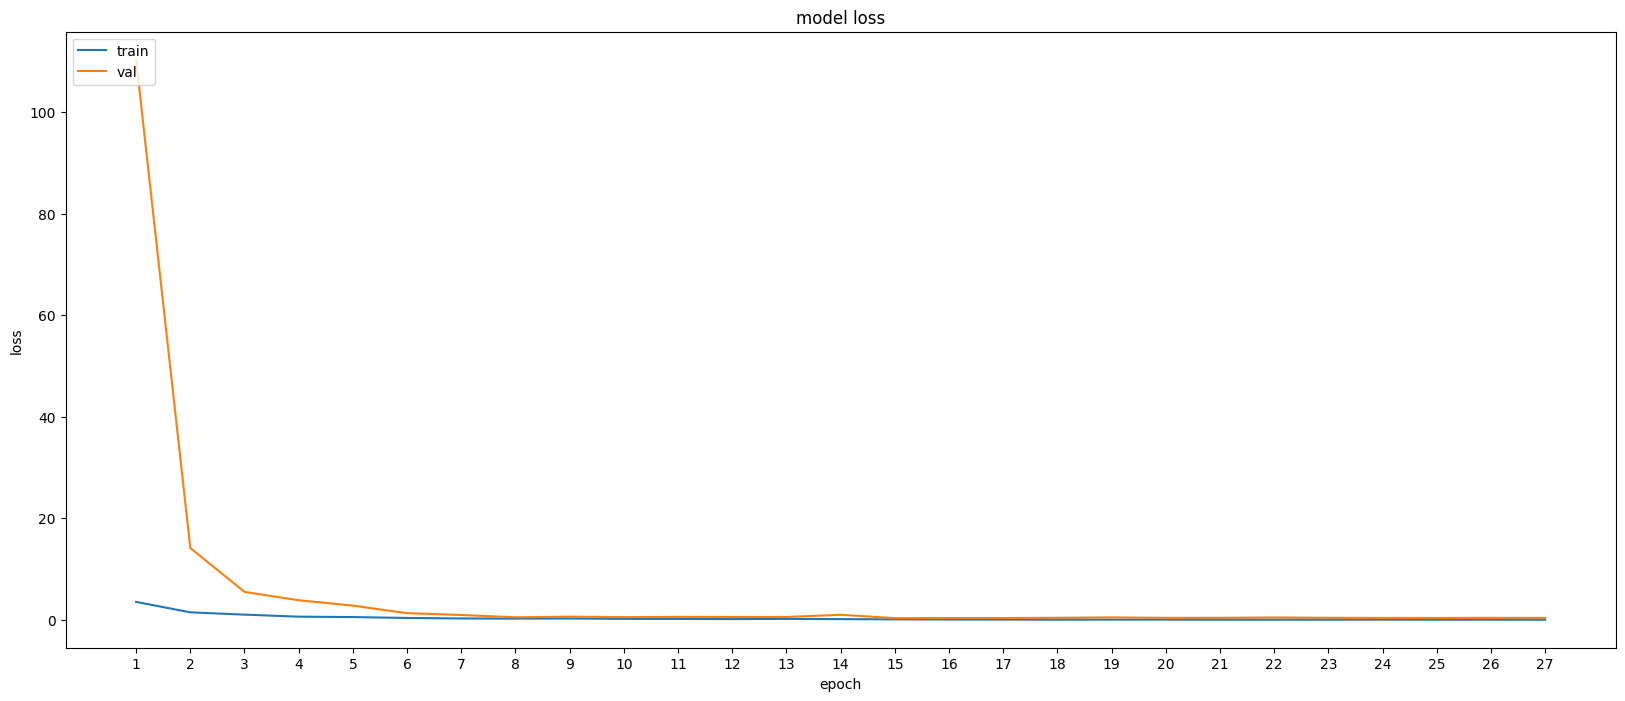

In [14]:
# Calculate the total number of epochs
total_epochs = len(history.history['loss'])

plt.figure(figsize=(20, 8))
plt.plot(range(1, total_epochs + 1), history.history['loss'])
plt.plot(range(1, total_epochs + 1), history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(1, total_epochs + 1))  # Set the x-axis tick positions explicitly
plt.legend(['train', 'val'], loc='upper left')
plt.show()

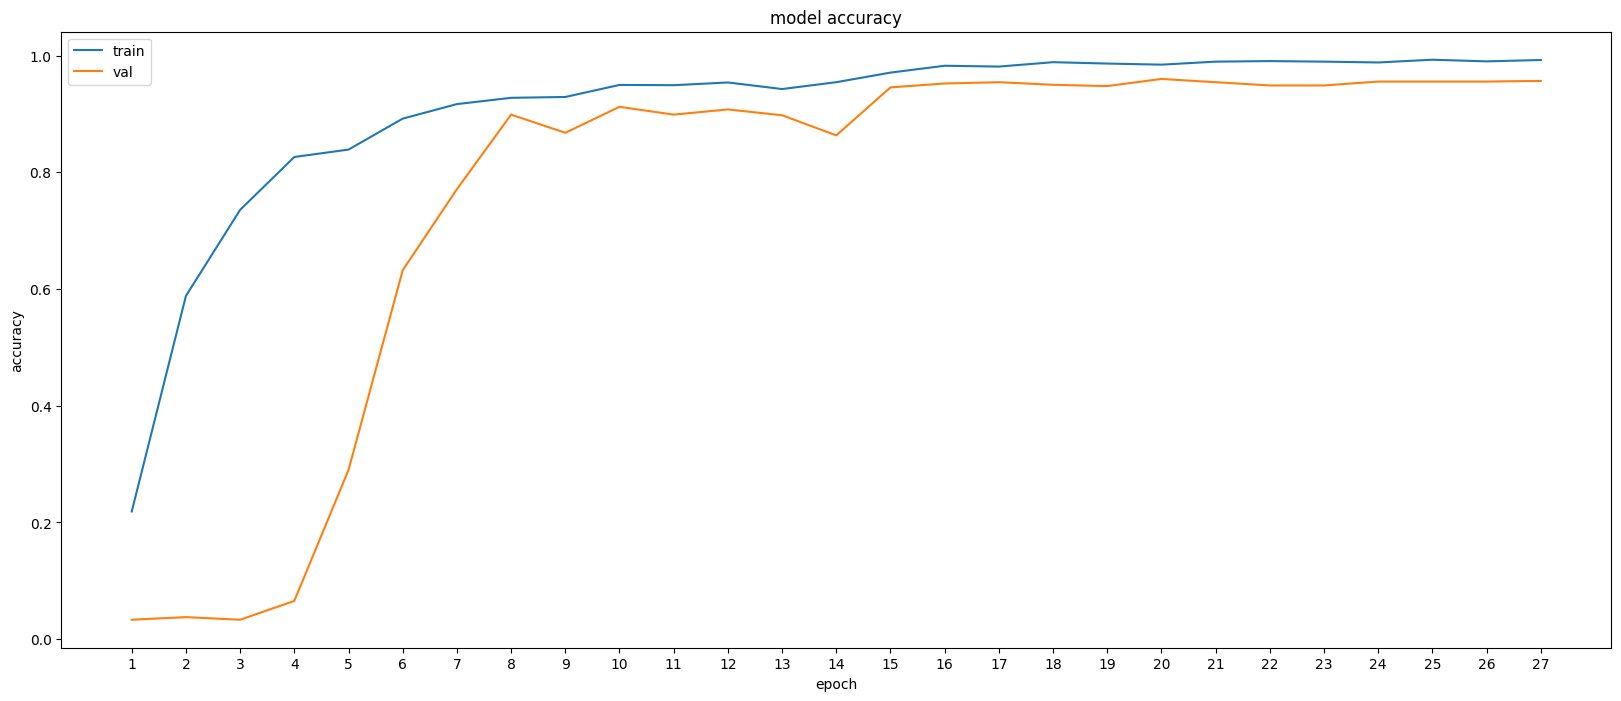

In [15]:
# Calculate the total number of epochs
total_epochs = len(history.history['accuracy'])

plt.figure(figsize=(20, 8))
plt.plot(range(1, total_epochs + 1), history.history['accuracy'])
plt.plot(range(1, total_epochs + 1), history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(1, total_epochs + 1))  # Set the x-axis tick positions explicitly
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Evalutation

In [16]:
# Assuming you have the true labels for your validation data
y_val = validation_generator.classes

# Make predictions using your model
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

57/57 [==============================] - 34s 569ms/step


In [17]:
# Calculate testing accuracy
accuracy = accuracy_score(y_val, y_pred)

print(f'Testing Accuracy: {accuracy * 100:.2f}%')

Testing Accuracy: 96.00%


## Class-Wise Performance Scores


In [18]:
# Generate a confusion matrix
confusion_mat = confusion_matrix(y_val, y_pred)

# Calculate class-wise metrics (Sensitivity, Specificity)
class_metrics = []
for class_id in range(train_num_classes):
    true_positives = confusion_mat[class_id, class_id]
    false_positives = confusion_mat[:, class_id].sum() - true_positives
    false_negatives = confusion_mat[class_id, :].sum() - true_positives
    true_negatives = confusion_mat.sum() - true_positives - false_positives - false_negatives

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    class_metrics.append({
        'Class': str(class_id),
        'Sensitivity': sensitivity,
        'Specificity': specificity,
    })

# Convert class-wise metrics to a DataFrame
class_metrics_df = pd.DataFrame(class_metrics)

In [19]:
# Generate a classification report
class_report_dict = classification_report(y_val, y_pred, target_names=[str(i) for i in range(train_num_classes)], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Merge class-wise metrics and classification report on the index (class names)
merged_metrics_df = pd.merge(class_metrics_df, class_report_df, left_on='Class', right_index=True)

# Print the merged table
print(merged_metrics_df)

   Class  Sensitivity  Specificity  precision    recall  f1-score  support
0      0     0.966667     1.000000   1.000000  0.966667  0.983051     30.0
1      1     1.000000     1.000000   1.000000  1.000000  1.000000     30.0
2      2     1.000000     0.997701   0.937500  1.000000  0.967742     30.0
3      3     0.966667     0.997701   0.935484  0.966667  0.950820     30.0
4      4     0.966667     0.998851   0.966667  0.966667  0.966667     30.0
5      5     1.000000     1.000000   1.000000  1.000000  1.000000     30.0
6      6     0.933333     1.000000   1.000000  0.933333  0.965517     30.0
7      7     1.000000     1.000000   1.000000  1.000000  1.000000     30.0
8      8     0.933333     0.996552   0.903226  0.933333  0.918033     30.0
9      9     1.000000     0.997701   0.937500  1.000000  0.967742     30.0
10    10     0.966667     0.996552   0.906250  0.966667  0.935484     30.0
11    11     1.000000     1.000000   1.000000  1.000000  1.000000     30.0
12    12     0.766667    

In [20]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [21]:
filenames = validation_generator.filenames

In [22]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

filename    actual predicted  Same
0  1-Pataka/15_Pataka.png  1-Pataka  1-Pataka  True
1  1-Pataka/21_Pataka.png  1-Pataka  1-Pataka  True
2  1-Pataka/22_Pataka.png  1-Pataka  1-Pataka  True
3  1-Pataka/23_Pataka.png  1-Pataka  1-Pataka  True
4  1-Pataka/24_Pataka.png  1-Pataka  1-Pataka  True
5  1-Pataka/26_Pataka.png  1-Pataka  1-Pataka  True
6  1-Pataka/27_Pataka.png  1-Pataka  1-Pataka  True
7  1-Pataka/28_Pataka.png  1-Pataka  1-Pataka  True
8  1-Pataka/29_Pataka.png  1-Pataka  1-Pataka  True
9   1-Pataka/2_Pataka.png  1-Pataka  1-Pataka  True

In [23]:
correctly_predicted = val_df[val_df['Same'] == True]
mis_predicted = val_df[val_df['Same'] == False]

correct_count = len(correctly_predicted)
mis_count = len(mis_predicted)

print("Correctly Predicted:", correct_count)
print("Mispredicted:", mis_count)

Correctly Predicted: 864
Mispredicted: 36


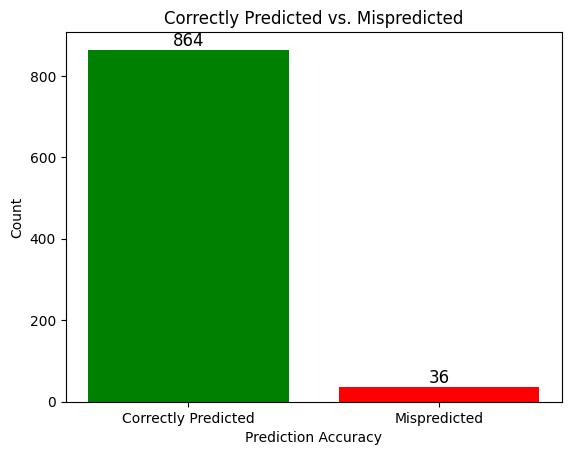

In [24]:
import matplotlib.pyplot as plt

# Data to plot
labels = ['Correctly Predicted', 'Mispredicted']
counts = [correct_count, mis_count]

# Create a bar graph
plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Count')
plt.title('Correctly Predicted vs. Mispredicted')

# Display count numbers on the bars
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

plt.show()


In [25]:
from sklearn.metrics import confusion_matrix

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Create a DataFrame to store class-wise counts
class_counts_df = pd.DataFrame({'Class': class_labels, 'Correctly Classified': np.diag(confusion_mat), 'Misclassified': np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)})

# Print the DataFrame (optional)
print(class_counts_df)


               Class  Correctly Classified  Misclassified
0           1-Pataka                    29              1
1         10-Shikara                    30              0
2         11-Kapitta                    30              0
3   12-Katakamukha_1                    29              1
4   12-Katakamukha_2                    29              1
5   12-Katakamukha_3                    30              0
6           13-Suchi                    28              2
7     14-Chandrakala                    30              0
8      15-Padmakosha                    28              2
9   16-Sarpashirasha                    30              0
10   17-Mrugashirsha                    29              1
11     18-Simhamukha                    30              0
12        19-Kangula                    23              7
13       2-Tripataka                    30              0
14       20-Alapadma                    30              0
15       21-Chathura                    26              4
16       22-Bh

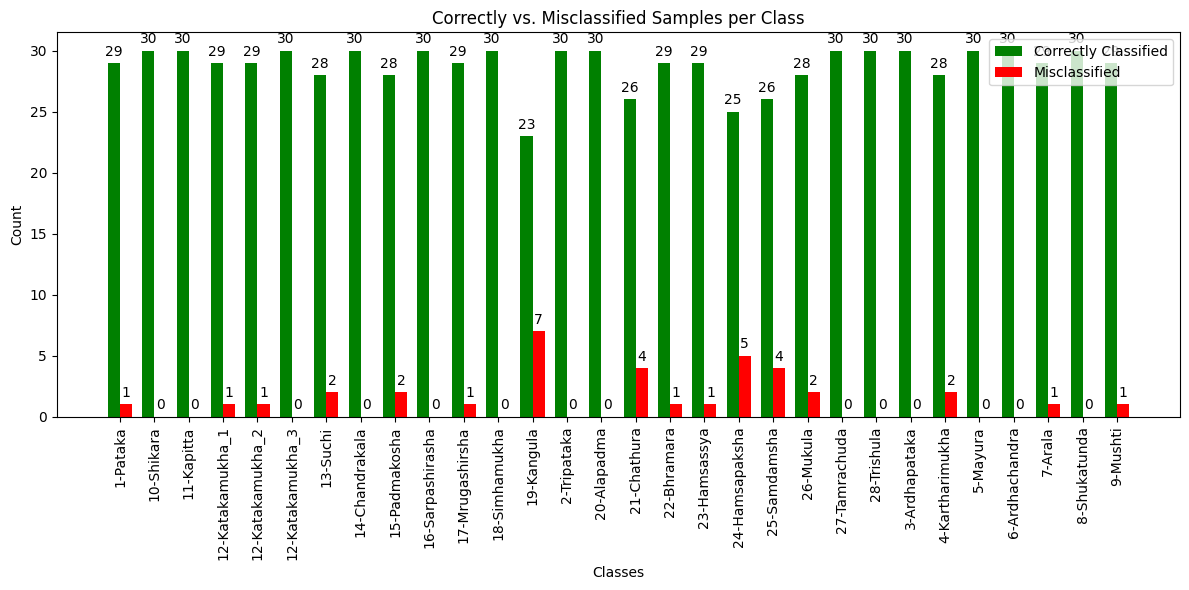

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(class_labels))

bar1 = ax.bar(index, class_counts_df['Correctly Classified'], bar_width, label='Correctly Classified', color='green')
bar2 = ax.bar(index + bar_width, class_counts_df['Misclassified'], bar_width, label='Misclassified', color='red')

ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_title('Correctly vs. Misclassified Samples per Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_labels, rotation=90)
ax.legend()

# Display count numbers on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [27]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

## Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'Pataka' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization**

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

### Image Visualization
- A: Actual P: Predicted
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)


In [28]:
import math

def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_width, img_height))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images_by_class(temp_df):
    unique_classes = temp_df['actual'].unique()

    for class_name in unique_classes:
        temp_df_class = temp_df[temp_df['actual'] == class_name]
        temp_df_class = temp_df_class.reset_index(drop=True)

        num_images = len(temp_df_class)
        num_rows = math.ceil(num_images / 5)  # Adjust the number of columns based on the number of images
        num_columns = min(num_images, 5)

        plt.figure(figsize=(20, num_rows * 4))
        plt.suptitle(f'Class: {class_name}', fontsize=14)

        for i in range(num_images):
            plt.subplot(num_rows, num_columns, i + 1)
            plt.subplots_adjust(hspace=0.3, wspace=0.5)

            image = readImage(f"/content/drive/MyDrive/Asamyuktha_Hastas/Testing Images/{temp_df_class.filename[i]}")
            plt.imshow(image)
            plt.title(f'A:{temp_df_class.actual[i]} P:{temp_df_class.predicted[i]}')

### Correctly Classified

In [ ]:
display_images_by_class(val_df[val_df['Same']==True])

### Misclassified

In [ ]:
display_images_by_class(val_df[val_df['Same']!=True])

### Grad-CAM Computation


In [31]:
def make_attention_gradcam_heatmap(img_array, model, pred_index=None):
    # Create a submodel that includes the attention layer and the output layer
    attention_layer = model.get_layer("conv5_block3_3_conv")
    classifier_layer = model.layers[-1]

    # Create a model that maps the input image to the activations of the attention layer and predictions
    grad_model = Model(inputs=model.inputs, outputs=[attention_layer.output, classifier_layer.output])

    # Start gradient tape to compute gradients
    with tf.GradientTape() as tape:
        attention_map, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients of the class with respect to the attention map
    grads = tape.gradient(class_channel, attention_map)

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the attention map by "how important this channel is" to the class
    attention_map = attention_map[0]
    heatmap = attention_map @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU operation on the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy(), preds


In [32]:
import matplotlib.cm as cm

In [33]:
val_df

filename            actual  \
0         3-Ardhapataka/58_Ardhapataka.png     3-Ardhapataka   
1              28-Trishula/58_Trishula.png       28-Trishula   
2    16-Sarpashirasha/59_Sarpashirasha.png  16-Sarpashirasha   
3           8-Shukatunda/63_Shukatunda.png      8-Shukatunda   
4     4-Kartharimukha/15_Kartharimukha.png   4-Kartharimukha   
..                                     ...               ...   
895                  13-Suchi/22_Suchi.png          13-Suchi   
896        27-Tamrachuda/23_Tamrachuda.png     27-Tamrachuda   
897   12-Katakamukha_3/35_Katakamukha3.png  12-Katakamukha_3   
898        15-Padmakosha/63_Padmakosha.png     15-Padmakosha   
899         8-Shukatunda/33_Shukatunda.png      8-Shukatunda   

            predicted  Same  
0       3-Ardhapataka  True  
1         28-Trishula  True  
2    16-Sarpashirasha  True  
3        8-Shukatunda  True  
4     4-Kartharimukha  True  
..                ...   ...  
895          13-Suchi  True  
896     27-Tamrachuda  True  
897  12-Katakamukha_3  True  
898     15-Padmakosha  True  
899      8-Shukatunda  True  

[900 rows x 4 columns]

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [34]:
def gradCAMImage(image):
    path = f"/content/drive/MyDrive/Asamyuktha_Hastas/Testing Images/{image}"
    img = readImage(path)
    img = np.expand_dims(img, axis=0)
    heatmap, preds = make_attention_gradcam_heatmap(img, model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.6 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

## Results

In [35]:
def gradcam_of_images(temp_df):
    grad_images = []
    titles = []
    unique_classes = temp_df['actual'].unique()

    for class_name in unique_classes:
        temp_df_class = temp_df[temp_df['actual'] == class_name]
        temp_df_class = temp_df_class.reset_index(drop=True)

        for i in range(len(temp_df_class)):
            image = temp_df_class.filename[i]
            grad_image = gradCAMImage(image)  # Replace with your actual gradCAM function
            grad_images.append(grad_image)
            titles.append(f"A:{temp_df_class.actual[i]} P:{temp_df_class.predicted[i]}")

    return grad_images, titles, unique_classes

In [36]:
def display_heatmaps_by_class(images, titles, class_names):
    num_images = len(images)

    for class_name in class_names:
        # Filter images and titles for the current class
        class_indices = [i for i, title in enumerate(titles) if title.startswith(f"A:{class_name}")]
        class_images = [images[i] for i in class_indices]
        class_titles = [titles[i] for i in class_indices]

        num_images_class = len(class_images)
        num_rows = math.ceil(num_images_class / 5)
        num_columns = min(num_images_class, 5)

        plt.figure(figsize=(20, num_rows * 5))
        plt.suptitle(f'Class: {class_name}', fontsize=14)

        for i in range(num_images_class):
            plt.subplot(num_rows, num_columns, i + 1)
            plt.subplots_adjust(hspace=0.1, wspace=0.5)
            plt.imshow(class_images[i], cmap='viridis')  # Use an appropriate colormap
            plt.title(class_titles[i])

        plt.show()


### Grad-CAM: Correctly Classified

In [ ]:
grad_images, titles, class_names = gradcam_of_images(val_df[val_df['Same']==True])
display_heatmaps_by_class(grad_images, titles, class_names)

**Inference:** As it can be seen some important features of the hand gestures are highlighted in the image
- Palm with presence of red ink
- Palm without presence of red ink
- Fingers posture/shape


### Grad-CAM: Incorrectly Classified

<ipython-input-34-f178ca5ed353>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]


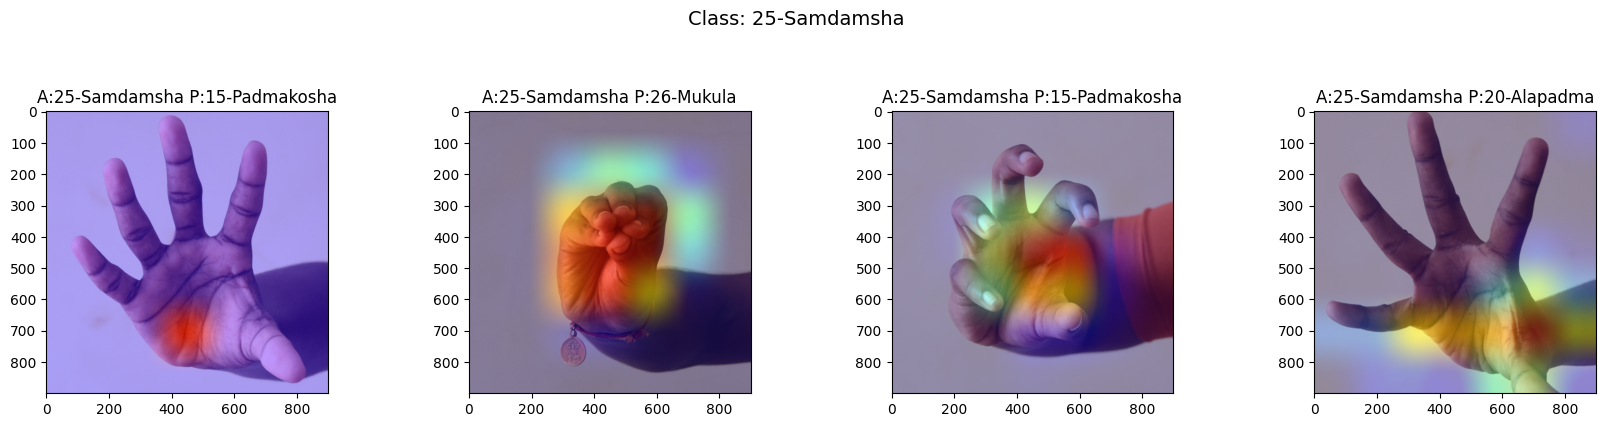

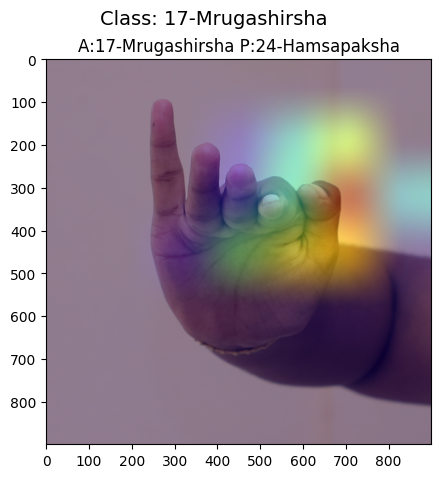

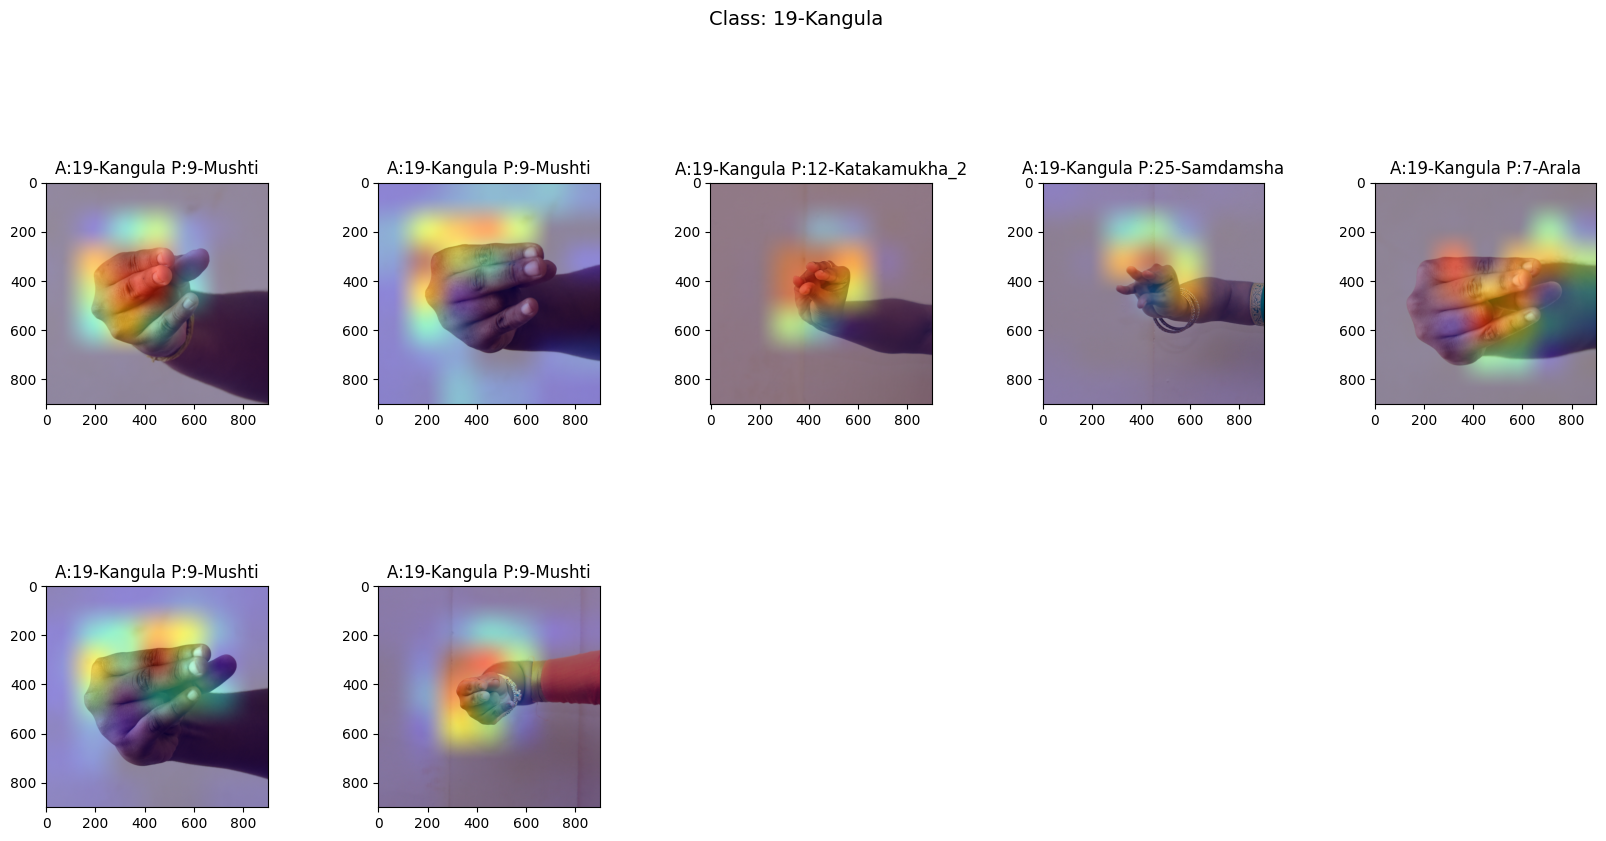

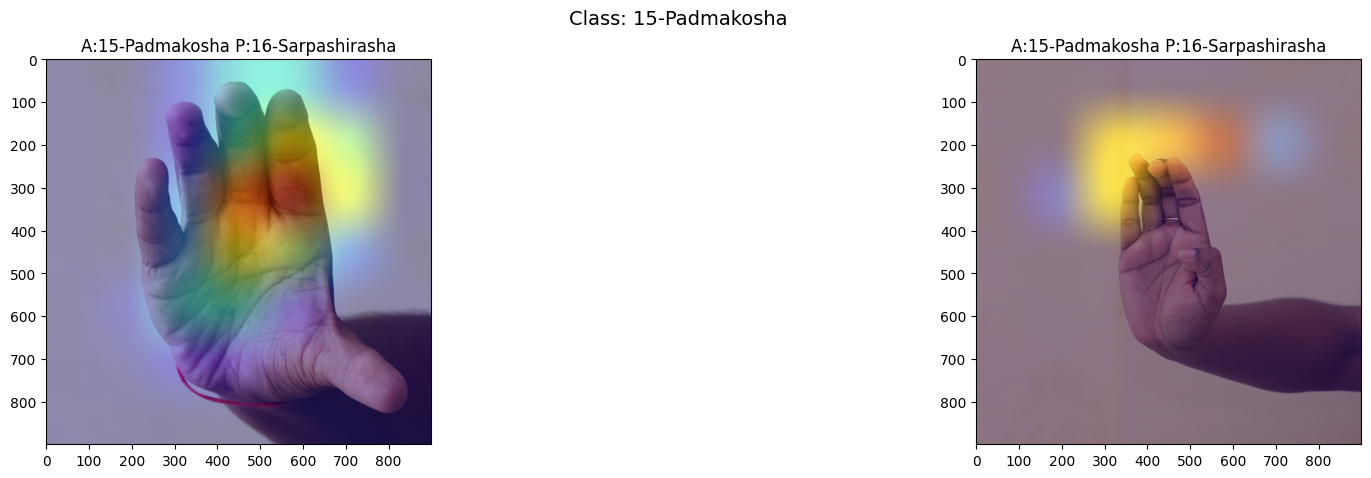

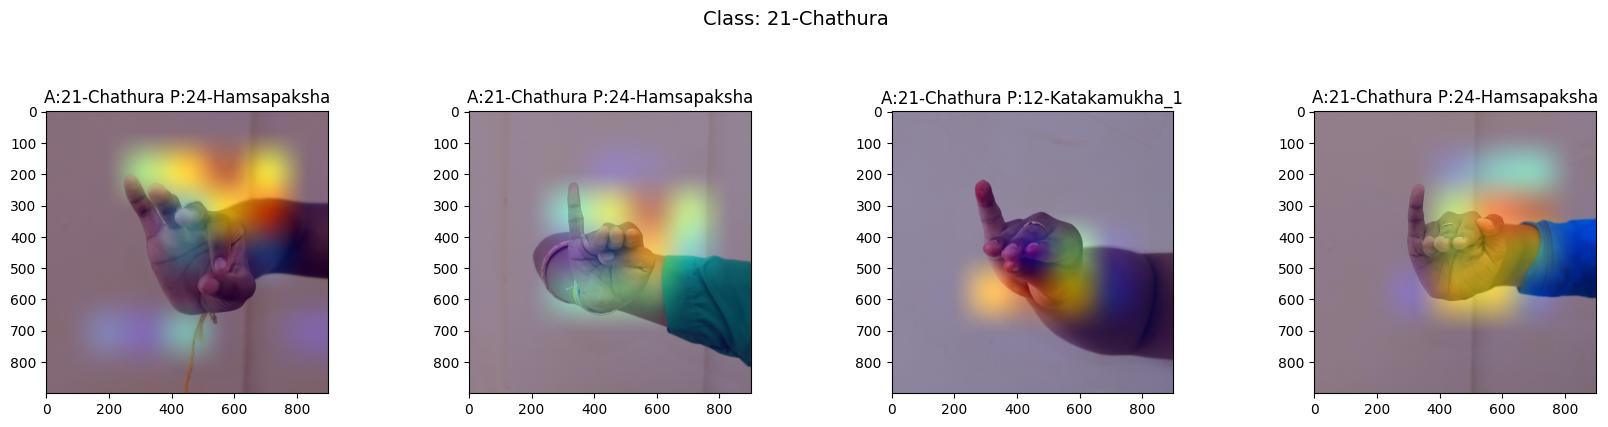

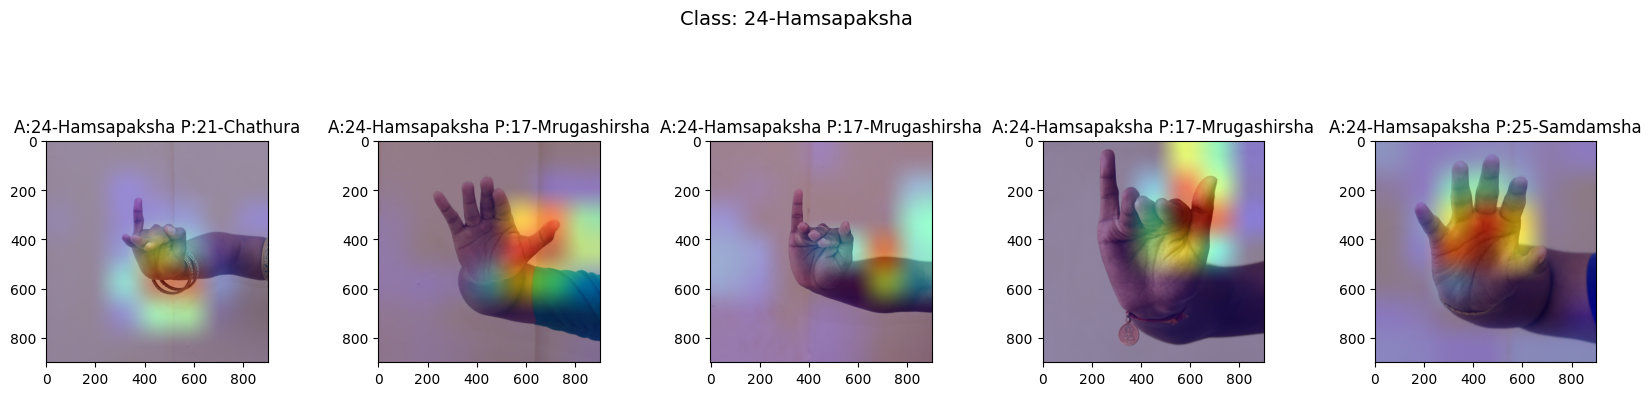

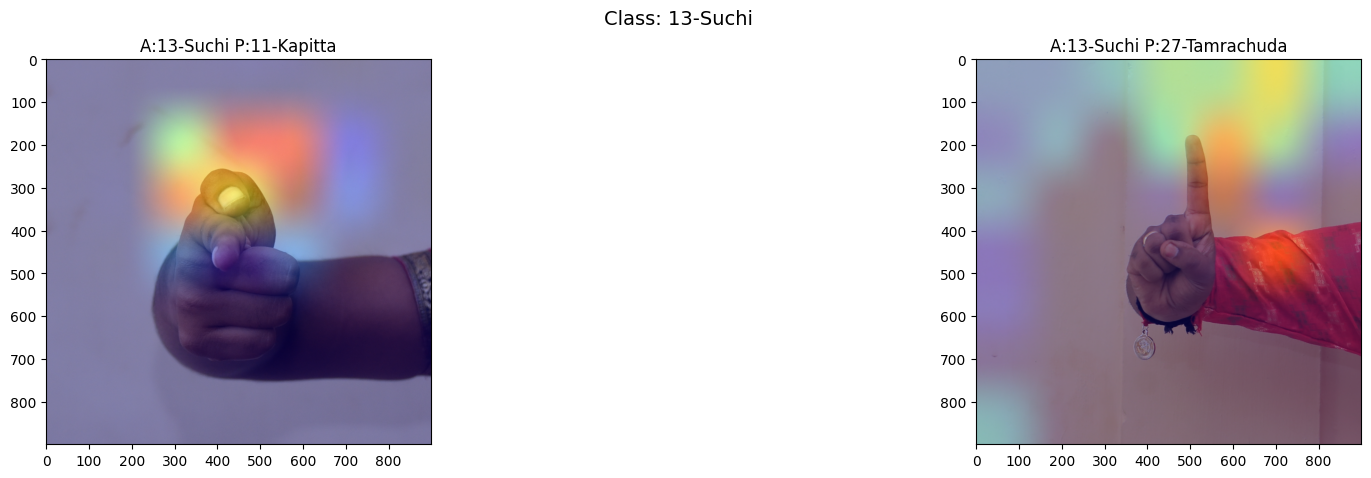

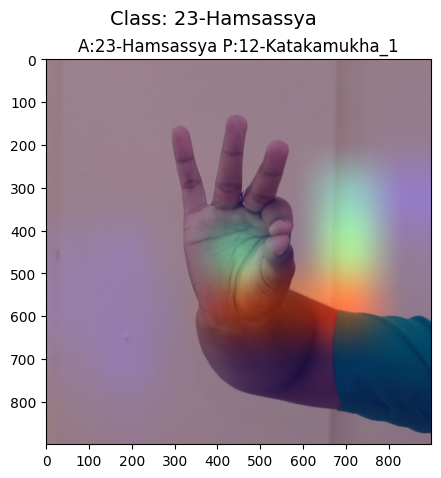

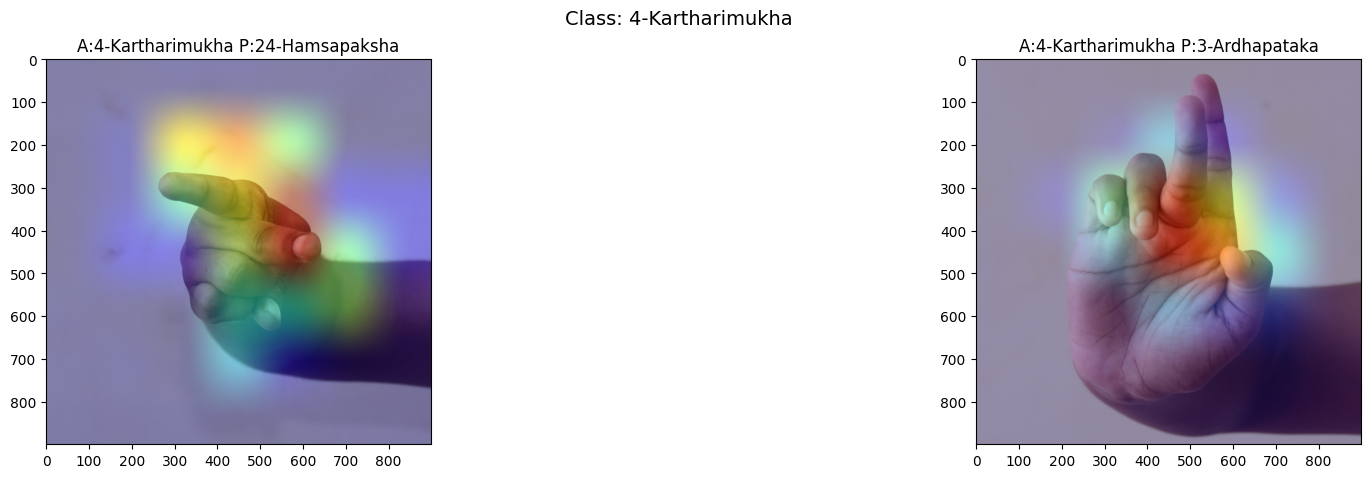

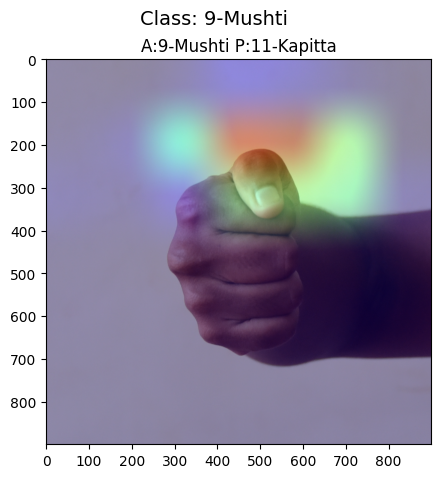

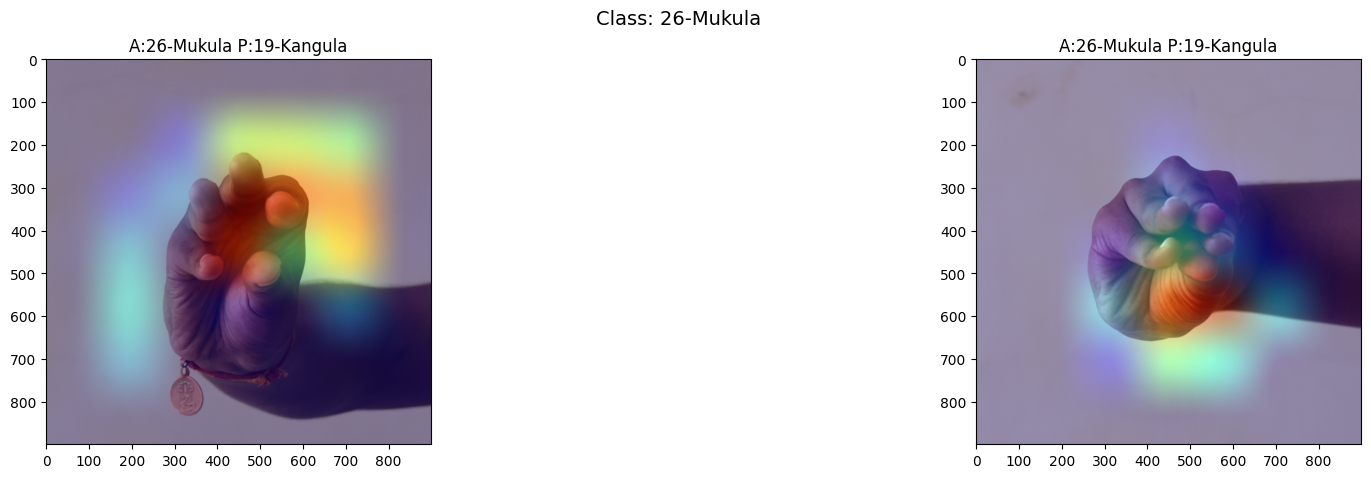

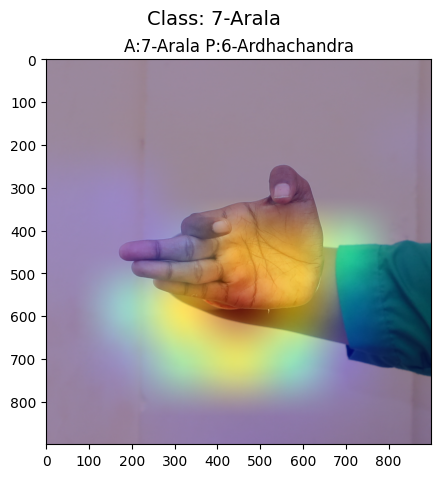

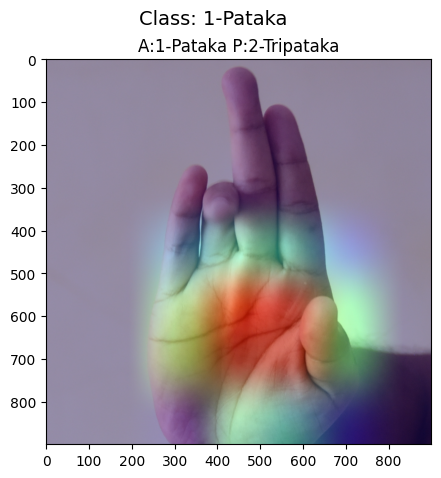

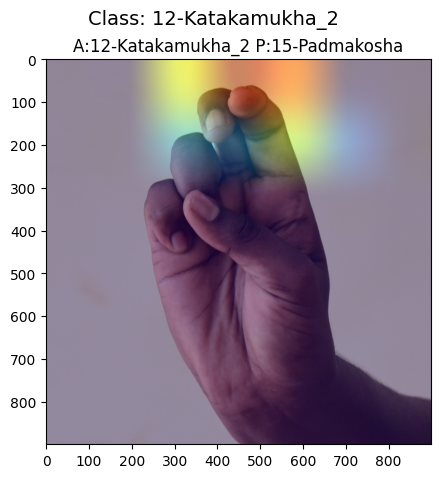

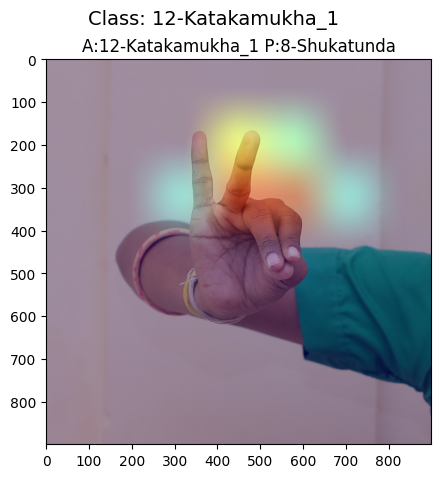

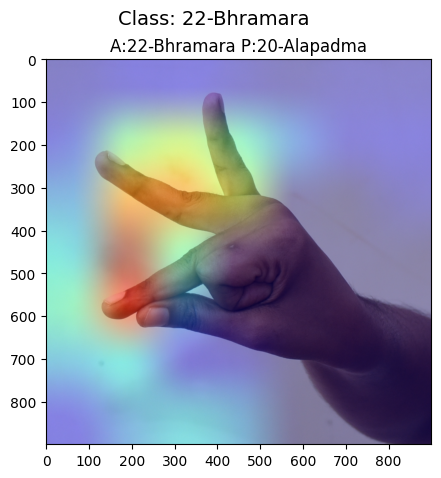

In [38]:
grad_images, titles, class_names = gradcam_of_images(val_df[val_df['Same']!=True])
display_heatmaps_by_class(grad_images, titles, class_names)

**Inference:** As it can be seen some features have been incorrectly detected on some of these hand gestures either due to the positioning of the hand/fingers in the image or due to the orientation of the image

These challenges can be resolved by changing the setting of augmentation techniques used in the model pipeline

## Hand Gesture Classification with ResNet50 and Hand Pose Estimation with Media Pipe

How to perform hand gesture classification using a fine-tuned ResNet50 model and hand pose estimation with MediaPipe.
It loads a ResNet50 model that has been trained to classify hand gestures and uses it to predict the gesture from an input image. It also uses MediaPipe to estimate hand landmarks and draws them on the image along with a bounding box. The predicted hand gesture class is displayed on the image.

In [39]:
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 21.3 MB/s eta 0:00:00


In [42]:
import mediapipe as mp

# Load your fine-tuned VGG16 model
model = load_model('/content/drive/MyDrive/Asamyuktha_Hastas/uniwifi_resnet50_freeze_last_15_layers.h5')

# Initialize MediaPipe Hand Pose Estimation
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Function to get hand landmarks using MediaPipe
def get_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        return results.multi_hand_landmarks[0]  # Assuming only one hand is present
    else:
        return None

# Function to make predictions using the VGG16 model
def predict_mudra(hand_landmarks, image_path):
    if hand_landmarks is not None:
        img = load_and_preprocess_image(image_path)
        prediction = model.predict(img)
        return prediction
    else:
        return None

# Function to draw hand landmarks and bounding box on the image
def draw_hand_landmarks(image, hand_landmarks):
    if hand_landmarks is not None:
        for landmark in hand_landmarks.landmark:
            height, width, _ = image.shape
            x, y = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Draw a green circle at each landmark

        # Calculate bounding box coordinates
        x_min, x_max, y_min, y_max = width, 0, height, 0
        for landmark in hand_landmarks.landmark:
            x, y = int(landmark.x * width), int(landmark.y * height)
            x_min = min(x_min, x)
            x_max = max(x_max, x)
            y_min = min(y_min, y)
            y_max = max(y_max, y)

        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Red bounding box

# Function to get the predicted class name
def get_predicted_class_name(prediction):
    if prediction is not None:
        class_index = np.argmax(prediction)
        class_names = os.listdir(test_data_dir)
        predicted_class_name = class_names[class_index]
        return predicted_class_name
    else:
        return "No Prediction"

1/1 [==============================] - 1s 1s/step


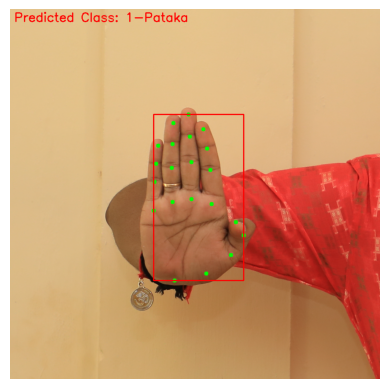

In [43]:
# Main function
def main(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Perform hand pose estimation using MediaPipe
    hand_landmarks = get_hand_landmarks(image)
    draw_hand_landmarks(image, hand_landmarks)  # Draw hand landmarks and bounding box on the image

    # Make predictions using the VGG16 model
    prediction = predict_mudra(hand_landmarks, image_path)

    # Get the predicted class name
    predicted_class_name = get_predicted_class_name(prediction)

    # Display the predicted class name
    cv2.putText(image, f"Predicted Class: {predicted_class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    return image

if __name__ == "__main__":
    input_image = "/content/drive/MyDrive/Asamyuktha_Hastas/Testing Images/1-Pataka/15_Pataka.png"
    result_image = main(input_image)

    # Display the result image
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

## Conclusion

The aim of this notebook was to demonstrate the Grad-CAM method and how it can be used to interpret the CNNs. Inferences from the the Grad-CAM visualizations can be used to further improve the model misclassifications and boost model performance